In [1]:
from pyspark.context import SparkContext

sc = SparkContext('local', 'test')

from pyspark.sql import SQLContext

spark = SQLContext(sc)

df_train = spark.read.parquet("parquet/train")
df_test = spark.read.parquet("parquet/test")

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F


df_labeled_train = df_train.withColumn("label",F.when(F.col("Income")==' <=50K',0).otherwise(1))

indexer_education = StringIndexer(inputCol="education", outputCol="educationIndex", handleInvalid='keep')
indexer_ocupation = StringIndexer(inputCol="occupation", outputCol="occupationIndex", handleInvalid='keep')
assembler = VectorAssembler(
    inputCols=["educationIndex", "occupationIndex", 'age'],
    outputCol="features")

naive_bayes  = NaiveBayes()

pipeline = Pipeline(stages = [indexer_education, indexer_ocupation,assembler,naive_bayes])

model = pipeline.fit(df_labeled_train)

In [4]:
df_labeled_test = df_test.withColumn("label",F.when(F.col("Income")==' <=50K',0).otherwise(1))

df_predictions = model.transform(df_labeled_test)

In [5]:
df_predictions.toPandas()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hours-per-week,native-country,income,label,educationIndex,occupationIndex,features,rawPrediction,probability,prediction
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,...,40.0,United-States,<=50K,0,5.0,6.0,"[5.0, 6.0, 25.0]","[-32.74944548514739, -35.8359311895271]","[0.9563318387892971, 0.04366816121070303]",0.0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,50.0,United-States,<=50K,0,0.0,10.0,"[0.0, 10.0, 38.0]","[-29.548822851159436, -34.01415162434334]","[0.9886298531344082, 0.011370146865591794]",0.0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,...,40.0,United-States,>50K,1,6.0,12.0,"[6.0, 12.0, 28.0]","[-49.83381268820575, -55.88344035686084]","[0.9976468104865331, 0.0023531895134669004]",0.0
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,40.0,United-States,>50K,1,1.0,6.0,"[1.0, 6.0, 44.0]","[-24.37202684430401, -26.491596494065]","[0.8927907453174381, 0.1072092546825618]",0.0
4,18.0,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,...,30.0,United-States,<=50K,0,1.0,7.0,"[1.0, 7.0, 18.0]","[-22.202731054896386, -26.101666409380677]","[0.9801389798707989, 0.019861020129201216]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39.0,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,...,36.0,United-States,<=50K,0,2.0,0.0,"[2.0, 0.0, 39.0]","[-12.759076775986122, -12.034621361557315]","[0.3264126258509391, 0.673587374149061]",1.0
16277,64.0,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,...,40.0,United-States,<=50K,0,0.0,7.0,"[0.0, 7.0, 64.0]","[-27.1632693734388, -28.81659951453765]","[0.8393406207233286, 0.16065937927667137]",0.0
16278,38.0,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,50.0,United-States,<=50K,0,2.0,0.0,"[2.0, 0.0, 38.0]","[-12.588049067410285, -11.912172469944649]","[0.33718222378346835, 0.6628177762165317]",1.0
16279,44.0,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,...,40.0,United-States,<=50K,0,2.0,3.0,"[2.0, 3.0, 44.0]","[-20.44648921955769, -21.02808911135567]","[0.6414354582714246, 0.3585645417285754]",0.0


In [7]:
df_predictions.select("label","prediction").groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 2091|
|    0|       0.0|10040|
|    1|       1.0| 1755|
|    0|       1.0| 2395|
+-----+----------+-----+



In [ ]:
# matriz de confusión

# +----------+---------+---------------+
# |          |  Pred1   |     Pred0    |
# +----------+---------+---------------+
# |  Actual1 | 1755    |  2091         |
# |  Actual0 | 2395    |  10040        |
# +----------+---------+---------------+

# Misclassification ratio: (2395+2091)/(1755+2091+2395+10040)
# Recall: 1755/(1755+2091)
# Precision: 1755/(1755+2395)
# TPR: = Recall = 1755/(1755+2091)
# FPR: FP / (TN + FP)  = 2395 / (10040 + 2395)
# Accuracy: (TP + TN) / (TP + TN + FN + FP) = (1755 + 10040)/(755+2091+2395+10040)


In [10]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def probability(vector):
    return float(vector[1])

probability_udf = udf(probability, DoubleType())

df_predictions_with_prob = df_predictions.withColumn("positive_probability", probability_udf(F.col("probability")))
df_predictions_with_prob.toPandas()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,native-country,income,label,educationIndex,occupationIndex,features,rawPrediction,probability,prediction,positive_probability
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,...,United-States,<=50K,0,5.0,6.0,"[5.0, 6.0, 25.0]","[-32.74944548514739, -35.8359311895271]","[0.9563318387892971, 0.04366816121070303]",0.0,0.043668
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,United-States,<=50K,0,0.0,10.0,"[0.0, 10.0, 38.0]","[-29.548822851159436, -34.01415162434334]","[0.9886298531344082, 0.011370146865591794]",0.0,0.011370
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,...,United-States,>50K,1,6.0,12.0,"[6.0, 12.0, 28.0]","[-49.83381268820575, -55.88344035686084]","[0.9976468104865331, 0.0023531895134669004]",0.0,0.002353
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,United-States,>50K,1,1.0,6.0,"[1.0, 6.0, 44.0]","[-24.37202684430401, -26.491596494065]","[0.8927907453174381, 0.1072092546825618]",0.0,0.107209
4,18.0,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,...,United-States,<=50K,0,1.0,7.0,"[1.0, 7.0, 18.0]","[-22.202731054896386, -26.101666409380677]","[0.9801389798707989, 0.019861020129201216]",0.0,0.019861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39.0,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,...,United-States,<=50K,0,2.0,0.0,"[2.0, 0.0, 39.0]","[-12.759076775986122, -12.034621361557315]","[0.3264126258509391, 0.673587374149061]",1.0,0.673587
16277,64.0,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,...,United-States,<=50K,0,0.0,7.0,"[0.0, 7.0, 64.0]","[-27.1632693734388, -28.81659951453765]","[0.8393406207233286, 0.16065937927667137]",0.0,0.160659
16278,38.0,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,United-States,<=50K,0,2.0,0.0,"[2.0, 0.0, 38.0]","[-12.588049067410285, -11.912172469944649]","[0.33718222378346835, 0.6628177762165317]",1.0,0.662818
16279,44.0,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,...,United-States,<=50K,0,2.0,3.0,"[2.0, 3.0, 44.0]","[-20.44648921955769, -21.02808911135567]","[0.6414354582714246, 0.3585645417285754]",0.0,0.358565


In [22]:
def confusion_matrix(df_predictions_with_prob, min_prob=0.7):
    df_with_pos_prediction = df_predictions_with_prob.withColumn("pos_prediction", 
                                                                 F.when(F.col("positive_probability")>=min_prob,1)
                                                                 .otherwise(0))
    return df_with_pos_prediction.select("label","pos_prediction").groupBy("label","pos_prediction").count()
    

    
    

In [23]:
confusion_matrix(df_predictions_with_prob, min_prob=0.7).toPandas()

,label,pos_prediction,count
0,1,0,3222
1,1,1,624
2,0,0,11748
3,0,1,687


In [24]:
confusion_matrix(df_predictions_with_prob, min_prob=0.8).toPandas()

,label,pos_prediction,count
0,1,0,3656
1,1,1,190
2,0,0,12231
3,0,1,204


In [25]:
confusion_matrix(df_predictions_with_prob, min_prob=0.9).toPandas()

,label,pos_prediction,count
0,1,0,3832
1,1,1,14
2,0,0,12415
3,0,1,20


In [64]:
def metrics(df_predictions_with_prob, min_prob):
    matrix = confusion_matrix(df_predictions_with_prob, min_prob)
    true_positives = matrix.select("count").where((F.col("label")==1) & (F.col("pos_prediction")==1)).collect()[0]["count"]
    all_positives =  matrix.select("count","label").where(F.col("label")==1).groupby("label").sum().collect()[0]["sum(count)"]
    tpr = true_positives / all_positives
    false_positives = matrix.select("count").where((F.col("label")==0) & (F.col("pos_prediction")==1)).collect()[0]["count"]
    all_negatives = matrix.select("count","label").where(F.col("label")==0).groupby("label").sum().collect()[0]["sum(count)"]
    fpr = false_positives / all_negatives
    return tpr, fpr

In [65]:
metrics(df_predictions_with_prob, min_prob=0.6)

(0.3159126365054602, 0.11001206272617611)

In [66]:
metrics(df_predictions_with_prob, min_prob=0.7)


(0.1622464898595944, 0.055247285886610376)

In [67]:
metrics(df_predictions_with_prob, min_prob=0.8)


(0.04940197607904316, 0.016405307599517492)

In [76]:
rates = [(p,metrics(df_predictions_with_prob, min_prob=p)) for p in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]]

In [77]:
rates

[(0.1, (0.8447737909516381, 0.6223562525130679)),
 (0.2, (0.765210608424337, 0.4604744672295939)),
 (0.3, (0.6859074362974519, 0.3613992762364294)),
 (0.4, (0.578263130525221, 0.2822677925211098)),
 (0.5, (0.45631825273010923, 0.19260152794531565)),
 (0.6, (0.3159126365054602, 0.11001206272617611)),
 (0.7, (0.1622464898595944, 0.055247285886610376)),
 (0.8, (0.04940197607904316, 0.016405307599517492)),
 (0.9, (0.003640145605824233, 0.0016083634901487736))]

In [80]:
import pandas as pd
df = pd.DataFrame([(p,tpr,fpr) for (p,(tpr,fpr)) in rates], columns=['p','tpr','fpr'])

<AxesSubplot:title={'center':'ROC (Receiver Operating Characteristic) Curve'}, xlabel='fpr', ylabel='tpr'>

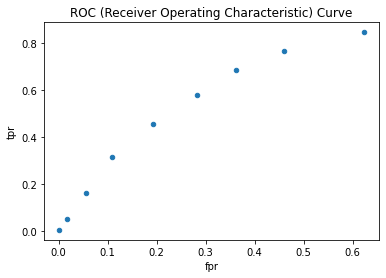

In [95]:
df.plot(kind='scatter',x='fpr',y='tpr', 
        title="ROC (Receiver Operating Characteristic) Curve")